## QQP
En este notebook se contesta cada pregunta del inciso B.

In [1]:
from pyspark import SparkContext
from pyspark.sql import Row
from pyspark.sql import SQLContext
sc =SparkContext()
sqlContext = SQLContext(sc)
df = sqlContext.read.csv('datos/all_data.csv', header=True, inferSchema= True)
df.printSchema()

root
 |-- producto: string (nullable = true)
 |-- presentacion: string (nullable = true)
 |-- marca: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- catalogo: string (nullable = true)
 |-- precio: double (nullable = true)
 |-- fechaRegistro: timestamp (nullable = true)
 |-- cadenaComercial: string (nullable = true)
 |-- giro: string (nullable = true)
 |-- nombreComercial: string (nullable = true)
 |-- direccion: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- latitud: string (nullable = true)
 |-- longitud: string (nullable = true)



# 1 Procesamiento de los datos

Podemos obtener esta información con queries de SQL.

a. ¿Cuántos registros hay?

In [2]:
df.count().show()

62530715


b. ¿Cuántas categorías?

In [7]:
df.registerTempTable('profeco')
query = sqlContext.sql('SELECT count(DISTINCT(categoria)) FROM profeco')
query.show()

+-------------------------+
|count(DISTINCT categoria)|
+-------------------------+
|                       41|
+-------------------------+



c. ¿Cuántas cadenas comerciales están siendo monitoreadas? 

In [8]:
query = sqlContext.sql('SELECT count(DISTINCT(cadenaComercial)) FROM profeco')
query.show()

+-------------------------------+
|count(DISTINCT cadenaComercial)|
+-------------------------------+
|                            705|
+-------------------------------+



d. ¿Cómo podrías determinar la calidad de los datos? ¿Detectaste algún tipo de 
inconsistencia o error en la fuente? 

La página del gobierno califica la calidad de los datos como "Calidad oro"; sin embargo, ésta solo la determinan con la existencia de algunos metadatos.

Para determinar la calidad del conjunto de datos se pueden hacer algunas pruebas como contar el número de valores faltantes o nulos por columna, contar el número de registros duplicados o asegurarse de que no se mezclen los datos entre colunas.

Aquí se cuentan los datos nulos por columna:

In [5]:
from pyspark.sql.functions import isnan, when, count, col, isnull
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+--------+------------+-----+---------+--------+------+-------------+---------------+----+---------------+---------+------+---------+-------+--------+
|producto|presentacion|marca|categoria|catalogo|precio|fechaRegistro|cadenaComercial|giro|nombreComercial|direccion|estado|municipio|latitud|longitud|
+--------+------------+-----+---------+--------+------+-------------+---------------+----+---------------+---------+------+---------+-------+--------+
|      20|          20|   20|   887358|     248|    20|           20|           1204| 307|             20|       20| 15074|    15074|  36834|   36834|
+--------+------------+-----+---------+--------+------+-------------+---------------+----+---------------+---------+------+---------+-------+--------+



Teniendo en cuenta el número de registros la mayoría de las columnas siempre tiene algún valor con la excepción de categoría. También existen siempre al menos 20 datos nulos probablemente de los mismos 20 registros por lo que podrían eliminarse. Además de esto se notaron inconsistencias en los datos, por ejemplo, se incluyen valores de marcas en la columna de productos o dirección en los estados. Obtener los mejores resultados de estos datos requeriría de algo de limpieza.

e. ¿Cuáles son los productos más monitoreados en cada entidad? 

Se obtienen los productos por estado con mayor número de registros.

In [16]:
edo_producto = sqlContext.sql('SELECT  estado, producto FROM ( SELECT estado, producto, count(producto) as q, ROW_NUMBER() OVER ( PARTITION BY estado ORDER BY count(producto) DESC) AS rn FROM profeco GROUP BY estado, producto) t WHERE rn = 1')
edo_producto.show()

+--------------------+--------------------+
|              estado|            producto|
+--------------------+--------------------+
|        QUINTANA ROO|                 FUD|
|          NUEVO LEÓN|   DETERGENTE P/ROPA|
|             SINALOA|            REFRESCO|
|             TABASCO|            REFRESCO|
|     BAJA CALIFORNIA|            REFRESCO|
|            TLAXCALA|            REFRESCO|
|COAHUILA DE ZARAGOZA|                 FUD|
|                null|LECHE ULTRAPASTEU...|
|       ESQ. SUR 125"|  PAN BLANCO BOLILLO|
| COL. EDUARDO GUERRA|            REFRESCO|
|             CHIAPAS|            REFRESCO|
|VERACRUZ DE IGNAC...|            REFRESCO|
|              SONORA|            REFRESCO|
|             YUCATÁN|LECHE ULTRAPASTEU...|
| MICHOACÁN DE OCAMPO|   DETERGENTE P/ROPA|
|             DURANGO|   DETERGENTE P/ROPA|
|            GUERRERO|            REFRESCO|
|             NAYARIT|            REFRESCO|
|           CHIHUAHUA|   DETERGENTE P/ROPA|
|    DISTRITO FEDERAL|          

f. ¿Cuál es la cadena comercial con mayor variedad de productos monitoreados? 

Cadena con más productos distintos.

In [21]:
cad_producto = sqlContext.sql('SELECT cadenaComercial, count(DISTINCT(producto)) as q FROM profeco GROUP BY cadenaComercial ORDER BY q DESC LIMIT 1')
cad_producto.show()

+---------------+----+
|cadenaComercial|   q|
+---------------+----+
|        SORIANA|1059|
+---------------+----+



Las 10 cadenas con mayor variedad:

In [22]:
cad_producto = sqlContext.sql('SELECT cadenaComercial, count(DISTINCT(producto)) as q FROM profeco GROUP BY cadenaComercial ORDER BY q DESC LIMIT 10')
cad_producto.show()

+--------------------+----+
|     cadenaComercial|   q|
+--------------------+----+
|             SORIANA|1059|
|            WAL-MART|1051|
|MEGA COMERCIAL ME...|1049|
|  COMERCIAL MEXICANA|1036|
|            CHEDRAUI|1026|
|     MERCADO SORIANA|1024|
|      BODEGA AURRERA|1012|
|HIPERMERCADO SORIANA|1006|
|              H.E.B.|1001|
|        SORIANA PLUS| 999|
+--------------------+----+



# 2 Análisis exploratorio

a. Genera una canasta de productos básicos que te permita comparar los precios 
geográfica y temporalmente. Justifica tu elección y procedimiento 

Al final se utilizó un subconjunto de la canasta que presenta el gobierno en sus [boletines de prensa](https://www.gob.mx/profeco/es/prensa/boletin-de-prensa-006-2018-publicara-profeco-semanalmente-comparativo-de-listado-de-precios-de-productos-de-canasta-basica?idiom=es). A continuación se explica el prodecimiento.

Primero observamos los distintos catálogos que existen en la tabla.

In [9]:
df.registerTempTable('profeco')
prods = sqlContext.sql('SELECT DISTINCT catalogo FROM profeco ORDER BY catalogo LIMIT 40')
prods.show()

+--------------------+
|            catalogo|
+--------------------+
|                null|
|             BASICOS|
|   ELECTRODOMESTICOS|
|  FRUTAS Y LEGUMBRES|
|            JUGUETES|
|        MEDICAMENTOS|
|            MERCADOS|
|           NAVIDEÑOS|
| PESCADOS Y MARISCOS|
|REGIONALES MONTERREY|
|               TENIS|
|    UTILES ESCOLARES|
|            catalogo|
+--------------------+



Al existir un catálogo de basicos podríamos suponer que estos cuentan con los productos más básicos para los mexicanos y podríamos contruir una canasta con base en ello.

Observamos las categorias del catálogo básico.

In [12]:
prods = sqlContext.sql('SELECT DISTINCT categoria FROM profeco WHERE catalogo = "BASICOS" ORDER BY categoria')
prods.show()

+--------------------+
|           categoria|
+--------------------+
|                null|
|ACCESORIOS DOMEST...|
|ACEITES Y GRASAS ...|
|ARROZ Y CEREALES ...|
|ARTS. DE PAPEL P/...|
|ARTS. PARA EL CUI...|
|              AZUCAR|
|                CAFE|
|        CARNE DE AVE|
|CARNE Y VISCERAS ...|
|CARNE Y VISCERAS ...|
|CARNES FRIAS SECA...|
|             CERVEZA|
|CHOCOLATES Y GOLO...|
|         CIGARRILLOS|
|         CONDIMENTOS|
|  DERIVADOS DE LECHE|
|DETERGENTES Y PRO...|
|FRUTAS Y LEGUMBRE...|
|GALLETAS PASTAS Y...|
+--------------------+
only showing top 20 rows



A pesar de estos datos, resulta muy difícil determinar un subconjunto de productos en estas categorías por lo que se buscó en internet información de PROFECO sobre su canasta básica.

Se encontraron algunos comunicados de prensa donde el PROFECO monitorea el precio de 12 productos de la canasta básica, afortunadamente en la tabla que muestran vienen los productos y presentaciones tal cual la ponen en la base de datos QQP. Para este ejercicio se tomaron 5 productos de los 12 que presenta el PROFECO. Se ordenan cronológicamente y se incluye información geográfica

In [27]:
canasta_prod = ['TORTILLA DE MAIZ','PAN BLANCO BOLILLO','JITOMATE','HUEVO','AZUCAR']
canasta_pres = ['1 KG. GRANEL','PIEZA','1KG. SALADETTE','PAQUETE CON 18 BLANCO','BOLSA PLASTICO 2 KG. ESTANDAR MORENA']
df_canasta = df.filter(df.producto.isin(canasta_prod) & df.presentacion.isin(canasta_pres)).select('producto','presentacion','precio','fechaRegistro','estado','municipio')
df_canasta.show()

+------------------+--------------------+------+-------------------+----------------+--------------------+
|          producto|        presentacion|precio|      fechaRegistro|          estado|           municipio|
+------------------+--------------------+------+-------------------+----------------+--------------------+
|PAN BLANCO BOLILLO|               PIEZA|   1.2|2011-01-10 00:00:00|          MÉXICO|ATIZAPAN         ...|
|            AZUCAR|BOLSA PLASTICO 2 ...|  34.9|2011-01-10 00:00:00|          MÉXICO|ATIZAPAN         ...|
|  TORTILLA DE MAIZ|        1 KG. GRANEL|   7.5|2011-01-10 00:00:00|          MÉXICO|ATIZAPAN         ...|
|            AZUCAR|BOLSA PLASTICO 2 ...|  34.9|2011-01-10 00:00:00|DISTRITO FEDERAL|BENITO JUAREZ    ...|
|             HUEVO|PAQUETE CON 18 BL...| 27.37|2011-01-10 00:00:00|DISTRITO FEDERAL|BENITO JUAREZ    ...|
|             HUEVO|PAQUETE CON 18 BL...|  24.1|2011-01-10 00:00:00|DISTRITO FEDERAL|BENITO JUAREZ    ...|
|  TORTILLA DE MAIZ|        1 KG. GRA

b. ¿Cuál es la ciudad más cara del país? ¿Cuál es la más barata? 

Tomando municipio como ciudad, primero obtenemos el precio promedio de cada producto de nuestra canasta por municipio.

In [50]:
df_canasta.registerTempTable('canasta')
precio_por_producto = sqlContext.sql('SELECT municipio, producto, MEAN(precio) FROM canasta GROUP BY municipio, producto')
precio_por_producto.show()

+--------------------+------------------+------------------+
|           municipio|          producto|       avg(precio)|
+--------------------+------------------+------------------+
|SAN PEDRO GARZA G...|  TORTILLA DE MAIZ|12.381562499999998|
|MONTERREY        ...|            AZUCAR| 30.96954088952653|
|              TOLUCA|            AZUCAR|29.420138888888907|
|LEON             ...|            AZUCAR|31.271872440023404|
|TLALNEPANTLA     ...|PAN BLANCO BOLILLO| 1.434066587395957|
|ECATEPEC         ...|             HUEVO|  34.6389055533036|
|             TORREÓN|            AZUCAR|30.800338983050843|
|          XOCHIMILCO|PAN BLANCO BOLILLO|1.4060606060606065|
|APODACA          ...|  TORTILLA DE MAIZ|12.338227394807516|
|ZAPOPAN          ...|PAN BLANCO BOLILLO|1.3577823129251705|
|HUAMANTLA        ...|  TORTILLA DE MAIZ| 9.686979865771812|
|             ORIZABA|            AZUCAR| 31.89189189189189|
|    GENERAL ESCOBEDO|PAN BLANCO BOLILLO|               2.1|
|CULIACAN         ...|  

Luego podemos obtener el precio de la canasta sumando los precios promedio por municipio. Finalmente obtenemos los 5 lugares más caros.

In [63]:
precio_por_producto.registerTempTable('promedios')
sqlContext.sql('SELECT municipio, SUM(precioPROMEDIO) AS precioCanasta FROM promedios GROUP BY municipio ORDER BY precioCanasta DESC LIMIT 5').show()

+--------------------+-----------------+
|           municipio|    precioCanasta|
+--------------------+-----------------+
|          HERMOSILLO|84.82004100216747|
|            MEXICALI|84.67196022015334|
|HERMOSILLO       ...|83.86985419297031|
|            ENSENADA|83.31922087652707|
|              LA PAZ| 82.8684817577774|
+--------------------+-----------------+



Y los 5 más baratos de acuerdo a nuestra canasta.

In [62]:
sqlContext.sql('SELECT municipio, SUM(precioPROMEDIO) AS precioCanasta FROM promedios GROUP BY municipio ORDER BY precioCanasta LIMIT 5').show()

+--------------------+------------------+
|           municipio|     precioCanasta|
+--------------------+------------------+
|TLAJOMULCO DE ZUÑ...| 8.426470588235293|
|ATIZAPAN DE ZARAG...| 10.58695652173913|
|SAN MATEO ATENCO ...|              10.7|
|ZINACANTEPEC     ...|11.262975778546712|
|ATIZAPÁN DE ZARAGOZA|11.267379679144385|
+--------------------+------------------+



c. ¿Hay algún patrón estacional entre años? 

Obtenemos el precio promedio de cada producto por mes y año.

In [65]:
historico_producto = sqlContext.sql('SELECT year(fechaRegistro) AS ano, month(fechaRegistro) AS mes, producto, MEAN(precio) AS precioCanasta FROM canasta GROUP BY ano, mes, producto ORDER BY ano, mes')
historico_producto.show()

+----+---+------------------+------------------+
| ano|mes|          producto|     precioCanasta|
+----+---+------------------+------------------+
|2011|  1|PAN BLANCO BOLILLO|1.2837943056362577|
|2011|  1|  TORTILLA DE MAIZ| 9.299332748024586|
|2011|  1|             HUEVO| 27.68583593750001|
|2011|  1|            AZUCAR|  32.6682958199357|
|2011|  2|PAN BLANCO BOLILLO|1.2932756324900128|
|2011|  2|             HUEVO|28.287561950439652|
|2011|  2|  TORTILLA DE MAIZ| 9.437223039215688|
|2011|  2|            AZUCAR|31.464102564102564|
|2011|  3|            AZUCAR| 31.26919885550787|
|2011|  3|PAN BLANCO BOLILLO|1.2895040369088806|
|2011|  3|             HUEVO|  28.4340393442623|
|2011|  3|  TORTILLA DE MAIZ| 9.756831075359868|
|2011|  4|  TORTILLA DE MAIZ|  9.93279515871204|
|2011|  4|             HUEVO| 27.73522297808012|
|2011|  4|PAN BLANCO BOLILLO|1.2904174340085937|
|2011|  4|            AZUCAR| 32.13459715639811|
|2011|  5|            AZUCAR|32.704333333333345|
|2011|  5|PAN BLANCO

Sumamos para obtener el precio de la canasta por mes y año.

In [67]:
historico_producto.registerTempTable('historico')
historico = sqlContext.sql('SELECT ano, mes, SUM(precioCanasta) AS precioBasica FROM historico GROUP BY ano, mes ORDER BY ano, mes')
historico.show()

+----+---+-----------------+
| ano|mes|     precioBasica|
+----+---+-----------------+
|2011|  1|70.93725881109656|
|2011|  2|70.48216318624792|
|2011|  3|70.74957331203892|
|2011|  4|71.09303272719886|
|2011|  5|71.12698336179568|
|2011|  6|71.32752552238836|
|2011|  7|72.67140631637109|
|2011|  8| 74.7232786457111|
|2011|  9|78.17886038719567|
|2011| 10| 80.3244355491251|
|2011| 11|81.96825220256306|
|2011| 12|83.17899660741341|
|2012|  1|83.78239184603271|
|2012|  2|81.96237583840743|
|2012|  3|81.63534306912058|
|2012|  4|79.81438073390377|
|2012|  5|79.03570987644252|
|2012|  6|78.50425678115938|
|2012|  7|79.94512974926916|
|2012|  8| 80.4972747467866|
+----+---+-----------------+
only showing top 20 rows



Se hace descomposición por estacionalidad y observamos gráficamente. Parece que los precios aumentan al final del año y diminuyen a mediados por lo que existe cierto patron de estacionalidad con nuestra canasta.

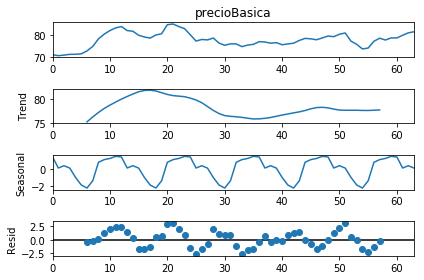

In [69]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

precios_mes = historico.toPandas().loc[:,'precioBasica']
decomposition = sm.tsa.seasonal_decompose(precios_mes, model='additive',period=12)
fig = decomposition.plot()
plt.show()

d. ¿Cuál es el estado más caro y en qué mes? 

e. ¿Cuáles son los principales riesgos de hacer análisis de series de tiempo con 
estos datos? 

Se tienen pocas variables que no toman en cuanta factores externos a solo los precios como puede ser la inflación. Se pueden cometer errores al predecir al no conocer otras variables y hacer modelos solo con los datos actuales.

# 3 Visualización
a. Genera un mapa que nos permita identificar la oferta de categorías en la zona 
metropolitana de León Guanajuato y el nivel de precios en cada una de ellas. Se 
darán puntos extra si el mapa es interactivo 

En este caso solo se seleccionaron datos del precio de una categoria: azúcar, debido a que hubieron complicaciones con la calidad de los datos.

In [2]:
df.registerTempTable('profeco')
m = sqlContext.sql('SELECT municipio FROM profeco WHERE estado ="GUANAJUATO"').first()
print(m)

Row(municipio='LEON                                    ')


In [3]:
leon = sqlContext.sql('SELECT MEAN(precio) as precioCategoria, latitud, longitud FROM profeco WHERE categoria="AZUCAR" AND estado="GUANAJUATO" AND municipio="LEON                                    " GROUP BY latitud, longitud')
leon.show()

+------------------+---------+-----------+
|   precioCategoria|  latitud|   longitud|
+------------------+---------+-----------+
| 35.56354748603352|21.095156| -101.62957|
|29.752475247524753|21.107162|-101.660872|
| 33.25969696969697|21.141389|-101.687397|
|28.238387096774197|21.148644|-101.704063|
|33.128729281767924|21.132543|-101.659225|
|  33.2878453038674|21.161521|-101.691985|
| 37.41382113821136|21.124324|-101.685945|
| 34.72023684210526|21.099966|-101.670745|
| 34.50390804597701|21.139468|  -101.6871|
| 33.41811594202899|21.146492|-101.684757|
|34.397590361445786|21.125658| -101.68559|
|31.885661764705873|21.103839|-101.693575|
+------------------+---------+-----------+



In [4]:
leon_cafe = leon.toPandas()
locations = leon_cafe[['latitud', 'longitud']].astype('double')
weight = leon_cafe['precioCategoria']

Se muestran los lugares donde se vende el azucar, entre más intenso el rojo el precio es más elevado. Debido a los pocos registros de la categoría seleccionada se ven puntos dispersos en el mapa.

In [7]:
import gmaps
gmaps.configure(api_key='AI')
fig = gmaps.figure()
leon_coordinates = ('21.1218562','-101.8060975')
gmaps.figure(center=leon_coordinates, zoom_level=12)
fig.add_layer(gmaps.heatmap_layer(locations, weights=weight))
fig

Figure(layout=FigureLayout(height='420px'))

![title](map.png)